In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import networkx as nx

In [2]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
(188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

tab20 = [tuple([float(c)/255.0 for c in t]) for t in tableau20]

In [7]:
pruning='0.3'

In [8]:
bud_df = pd.read_csv('/Users/joelforster/Projects/optidb/clus/opti-bud.csv',names=['e','n','bud_number','size','bud_percentage','mean_budtime'])
net_df = pd.read_csv('/Users/joelforster/Projects/optidb/clus/opti-net'+pruning+'.csv',header=0)




In [9]:
len(net_df.columns.values.tolist())

22

In [10]:
cols = [x for i,x in enumerate(net_df.columns.values.tolist()) if i!=2 and i<18]

In [11]:
net_df = net_df.drop_duplicates(cols)

In [12]:
for c in bud_df.columns:
    bud_df[c] = bud_df[c].astype(float)
for c in net_df.columns:
    net_df[c] = net_df[c].astype(float)

In [13]:
# net_df.head(5)

In [14]:
criticalRegion = bud_df.query('bud_percentage > 0.2 & bud_percentage < 0.8 & e*n < 320')[['e','n']].values.tolist()
criticalNets = pd.DataFrame(columns=net_df.columns)
for c in criticalRegion:
    runNets = net_df[(net_df['Mean Affinity']==c[1]) & (net_df['Ligand Number']==c[0])]
    criticalNets = criticalNets.append(runNets)

In [15]:
print criticalRegion

[[20.0, 13.0], [20.0, 14.0], [21.0, 12.0], [21.0, 13.0], [21.0, 14.0], [22.0, 12.0], [22.0, 13.0], [22.0, 14.0], [23.0, 10.0], [23.0, 11.0], [23.0, 12.0], [23.0, 13.0], [24.0, 10.0], [24.0, 11.0], [24.0, 12.0], [24.0, 13.0], [25.0, 9.0], [25.0, 10.0], [25.0, 11.0], [25.0, 12.0], [26.0, 9.0], [26.0, 10.0], [26.0, 11.0], [27.0, 9.0], [27.0, 10.0], [28.0, 9.0], [28.0, 10.0], [29.0, 8.0], [29.0, 9.0], [30.0, 8.0], [30.0, 9.0], [31.0, 8.0], [31.0, 7.0], [32.0, 8.0], [32.0, 7.0], [33.0, 8.0], [33.0, 7.0], [34.0, 7.0], [35.0, 6.0], [35.0, 7.0], [36.0, 6.0], [37.0, 6.0], [38.0, 6.0], [39.0, 6.0], [40.0, 6.0], [42.0, 5.0], [43.0, 5.0], [44.0, 5.0], [45.0, 5.0], [46.0, 5.0], [50.0, 4.0], [51.0, 4.0], [52.0, 4.0], [53.0, 4.0], [54.0, 4.0]]


In [16]:
budNets = criticalNets[criticalNets['Mean Budding Time'] > 0.0].groupby(['Mean Affinity','Ligand Number']).mean().reset_index()
nonbudNets = criticalNets[criticalNets['Mean Budding Time'] < 0.0].groupby(['Mean Affinity','Ligand Number']).mean().reset_index()

In [17]:
meanBudNets = criticalNets[criticalNets['Mean Budding Time'] > 0.0].groupby(['Ligand Number']).mean().reset_index()
meanNonbudNets = criticalNets[criticalNets['Mean Budding Time'] < 0.0].groupby(['Ligand Number']).mean().reset_index()

248.54545454545453 200.0 312.0 28.80013774071745


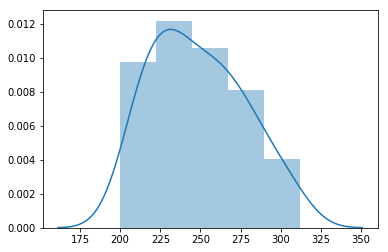

In [18]:
criticalEnergy = map(lambda x: x[0]*x[1],criticalRegion)
ax = sns.distplot(criticalEnergy)
print np.mean(criticalEnergy) , np.min(criticalEnergy), np.max(criticalEnergy),np.std(criticalEnergy)


In [19]:
bins = np.linspace(0, 100, 26)
print bins

digitisedLigandNum = np.digitize(budNets["Ligand Number"], bins)
binnedLigandNum = [budNets["Ligand Number"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]
binnedNonBudLigandNum = [nonbudNets["Ligand Number"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]
binnedBuddingRate = [budNets["Budding Rate"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]

binnedLigandNum = [b for b in binnedLigandNum if not np.isnan(b)]
binnedNonBudLigandNum = [b for b in binnedNonBudLigandNum if not np.isnan(b)]
binnedBuddingRate = [b for b in binnedBuddingRate if not np.isnan(b)]

[  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.
  56.  60.  64.  68.  72.  76.  80.  84.  88.  92.  96. 100.]


In [20]:
def buildBinnedPlot(c):
    binnedBudC = [budNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
    binnedBudyErr = [b for b in [np.std(budNets[c][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
    binnedBudxErr = [b for b in [np.std(budNets["Ligand Number"][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
    binnedBudC = [b for b in binnedBudC if not np.isnan(b)]
    binnedNoBudC = [nonbudNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
    binnedNoBudC = [b for b in binnedNoBudC if not np.isnan(b)]
    binnedNoBudyErr = [b for b in [np.std(nonbudNets[c][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
    binnedNoBudxErr = [b for b in [np.std(nonbudNets["Ligand Number"][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
    return binnedBudC,binnedBudxErr,binnedBudyErr,binnedNoBudC,binnedNoBudxErr,binnedNoBudyErr

In [21]:
def buildHistPlot(c,n):
    budPop = criticalNets[(criticalNets['Mean Budding Time'] > 0.0)&(criticalNets['Ligand Number']==float(n))][c].values.tolist()
    nonBudPop = criticalNets[(criticalNets['Mean Budding Time'] < 0.0)&(criticalNets['Ligand Number']==float(n))][c].values.tolist()
    return budPop, nonBudPop
    

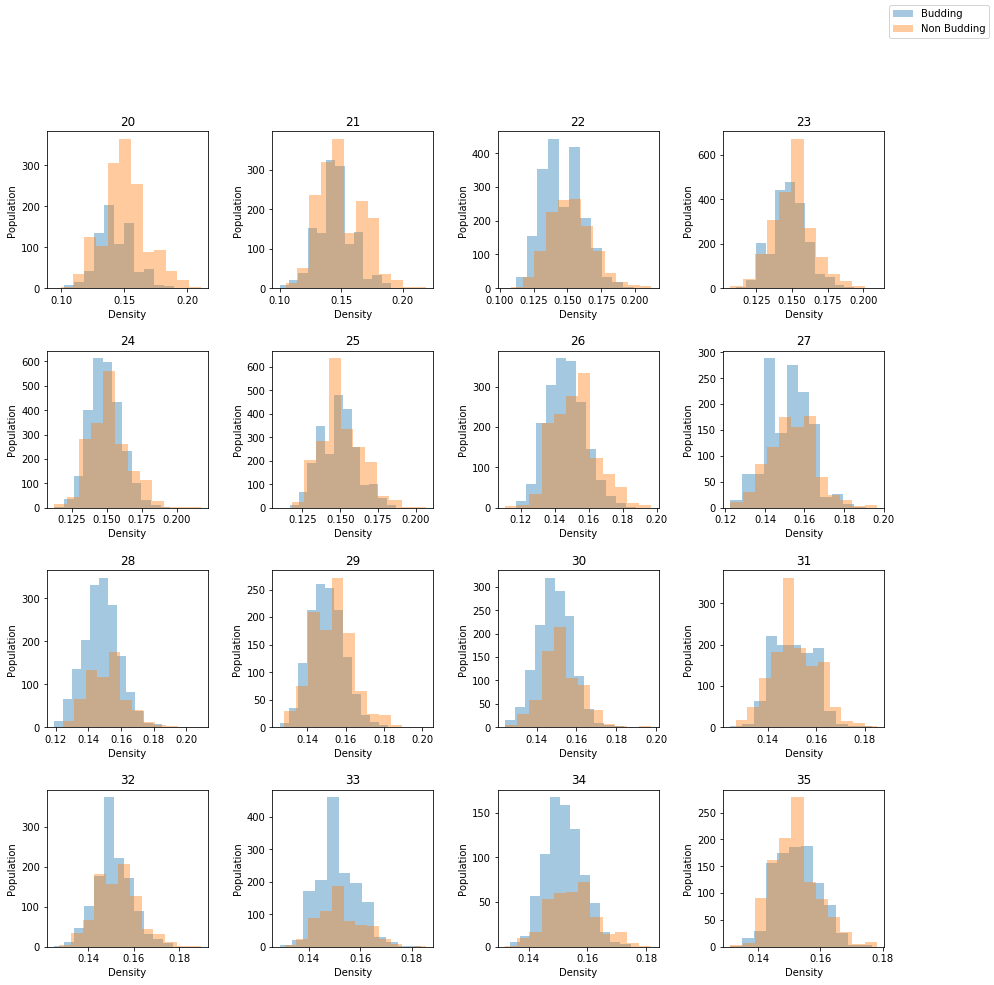

In [22]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
startI = 20
for i in range(startI,startI+16):
    ax = plt.subplot(4, 4, i-startI+1)
    r = buildHistPlot("Density",i)
    ax = sns.distplot(r[0],label="Budding",bins=12,kde=False)
    ax = sns.distplot(r[1],label="Non Budding",bins=12,kde=False)
    ax.set_xlabel("Density")
    ax.set_ylabel("Population")
    ax.set_title(i)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

In [26]:
labelSize=22
tickSize=20

In [27]:
def bigFig(c,label="NONE"):
    padding=0.025
    sns.set_style("white")
    if label=="NONE":
        label = c
    plt.figure(figsize=(12,7.5))
    ax = plt.subplot(111)

    r = [int(np.floor(min(budNets[c])*1000)), int(np.ceil(max(budNets[c])*1000)+1)]
    # for y in range(r[0],r[1]):    
    #     plt.plot(range(r[0],r[1]), [y] * len(range(r[0],r[1])), "--", lw=0.5, color="black", alpha=0.3)

    xr = range(int(np.floor(min(budNets['Ligand Number']))-1), int(np.ceil(max(budNets['Ligand Number']))+2))

    # for y in range(r[0],r[1]):    
    #     plt.plot(xr, [y*0.001] * len(xr) , "--", lw=0.5, color="black", alpha=0.3)    


    r = buildBinnedPlot(c)

#     plt.errorbar(binnedLigandNum,r[0],xerr=r[1],yerr=r[2],fmt='o',label="Budding")
#     plt.errorbar(binnedNonBudLigandNum,r[3],yerr=r[5],xerr=r[4],fmt='o',label="Non Budding")

    plt.errorbar(binnedLigandNum,r[0],fmt='-o',label="Budding")
    
    if np.mean(r[3]) > 0.1:
        plt.errorbar(binnedNonBudLigandNum,r[3],fmt='-o',label="Non Budding")

    yerrbud1 = [e[0]-e[1] for e in  zip(r[0],r[2])]
    yerrbud2 = [e[0]+e[1] for e in  zip(r[0],r[2])]

    yerrnobud1 = [e[0]-e[1] for e in  zip(r[3],r[5])]
    yerrnobud2 = [e[0]+e[1] for e in  zip(r[3],r[5])]

    ax.fill_between(binnedLigandNum,yerrbud1, yerrbud2, where=yerrbud2 >= yerrbud1, facecolor=tab20[1], interpolate=True,alpha=0.5)
    if np.mean(r[3]) > 0.1:
        ax.fill_between(binnedLigandNum,yerrnobud1, yerrnobud2, where=yerrnobud2 >= yerrnobud1, facecolor=tab20[3], interpolate=True,alpha=0.5)

    yr0 = np.min([yerrbud1,yerrbud2,yerrnobud1,yerrnobud2])*(1.0-padding)
    yr1 = np.max([yerrbud1,yerrbud2,yerrnobud1,yerrnobud2])*(1.0+padding)
    plt.ylabel(label,fontsize=labelSize)
    plt.xlabel("Ligand Number",fontsize=labelSize)
    plt.xticks(fontsize=tickSize)
    plt.yticks(fontsize=tickSize)
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False) 
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()   
#     ax.set_ylim(yr0,yr1)
    plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                    labelbottom="on", left="off", right="off", labelleft="on")  
    plt.legend(loc='best',fontsize=labelSize)
    plt.savefig('/Users/joelforster/Projects/Figures/eps/'+label.replace(' ','-')+'-LigandNumber.eps', format='eps', dpi=1000)
    plt.savefig('/Users/joelforster/Projects/Figures/png/'+label.replace(' ','-')+'-LigandNumber.png')
    plt.savefig('/Users/joelforster/Projects/Figures/svg/'+label.replace(' ','-')+'-LigandNumber.svg', format='svg')
    plt.cla()
    plt.clf()

In [28]:
for c in budNets.columns:
    bigFig(c)


/Users/joelforster/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/joelforster/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

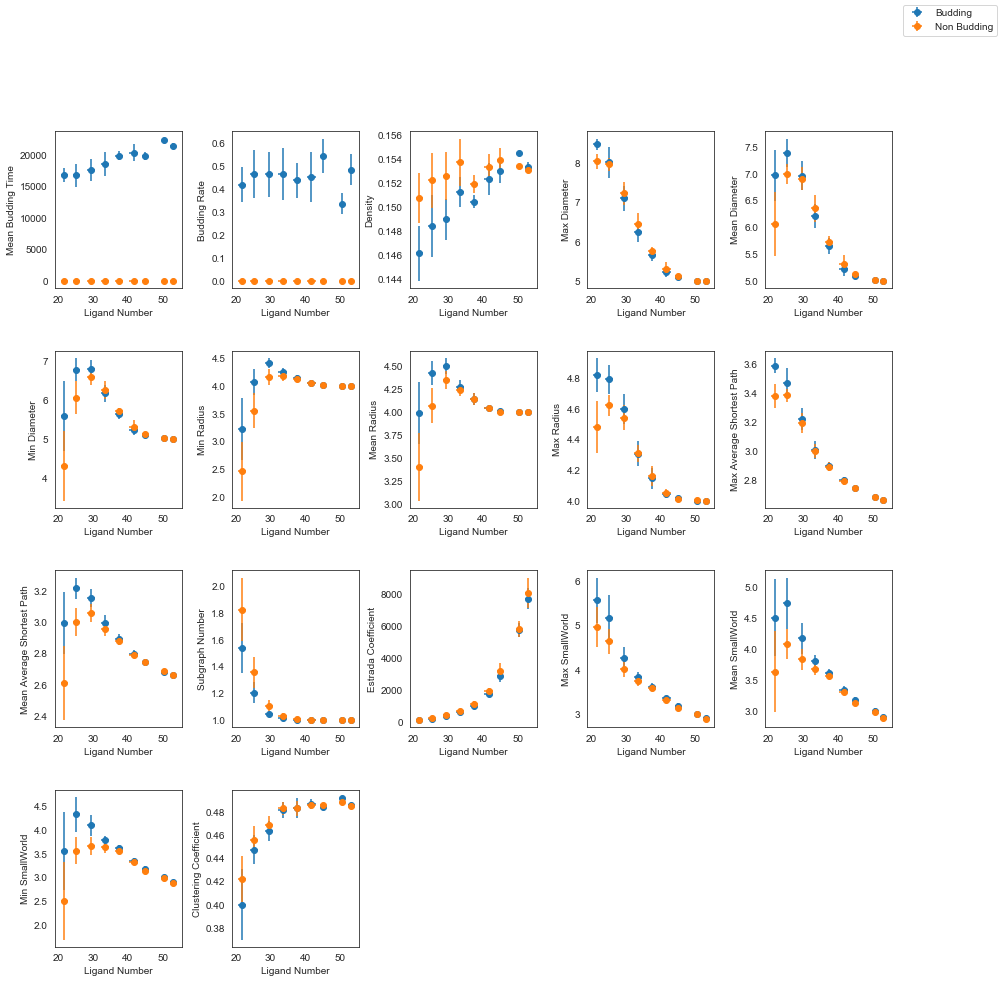

In [29]:
i = 1


fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in budNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(4, 5, i)
#     binnedBudC = [budNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
#     binnedBudyErr = [b for b in [np.std(budNets[c][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
#     binnedBudxErr = [b for b in [np.std(budNets["Ligand Number"][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
#     binnedBudC = [b for b in binnedBudC if not np.isnan(b)]
#     binnedNoBudC = [nonbudNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
#     binnedNoBudC = [b for b in binnedNoBudC if not np.isnan(b)]
#     binnedNoBudyErr = [b for b in [np.std(nonbudNets[c][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
#     binnedNoBudxErr = [b for b in [np.std(nonbudNets["Ligand Number"][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
    r = buildBinnedPlot(c)
    ax.errorbar(binnedLigandNum,r[0],xerr=r[1],yerr=r[2],fmt='o',label="Budding")
    ax.errorbar(binnedNonBudLigandNum,r[3],yerr=r[5],xerr=r[4],fmt='o',label="Non Budding")
    #ax.plot(binnedLigandNum,binnedBudC,'.',label="Budding")
    plt.ylabel(c)
    plt.xlabel("Ligand Number")
    
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

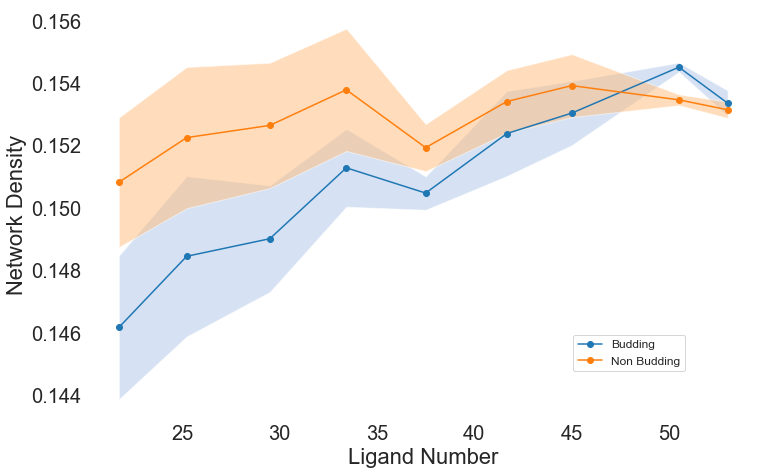

In [30]:
plt.figure(figsize=(12,7.5))
ax = plt.subplot(111)

r = [int(np.floor(min(budNets['Density'])*1000)), int(np.ceil(max(budNets['Density'])*1000)+1)]
# for y in range(r[0],r[1]):    
#     plt.plot(range(r[0],r[1]), [y] * len(range(r[0],r[1])), "--", lw=0.5, color="black", alpha=0.3)

xr = range(int(np.floor(min(budNets['Ligand Number']))-1), int(np.ceil(max(budNets['Ligand Number']))+2))

# for y in range(r[0],r[1]):    
#     plt.plot(xr, [y*0.001] * len(xr) , "--", lw=0.5, color="black", alpha=0.3)    
 
    
r = buildBinnedPlot("Density")

plt.errorbar(binnedLigandNum,r[0],fmt='-o',label="Budding")
plt.errorbar(binnedNonBudLigandNum,r[3],fmt='-o',label="Non Budding")

yerrbud1 = [e[0]-e[1] for e in  zip(r[0],r[2])]
yerrbud2 = [e[0]+e[1] for e in  zip(r[0],r[2])]

yerrnobud1 = [e[0]-e[1] for e in  zip(r[3],r[5])]
yerrnobud2 = [e[0]+e[1] for e in  zip(r[3],r[5])]

ax.fill_between(binnedLigandNum,yerrbud1, yerrbud2, where=yerrbud2 >= yerrbud1, facecolor=tab20[1], interpolate=True,alpha=0.5)
ax.fill_between(binnedLigandNum,yerrnobud1, yerrnobud2, where=yerrnobud2 >= yerrnobud1, facecolor=tab20[3], interpolate=True,alpha=0.5)

    
# plt.plot(budNets["Ligand Number"],budNets['Density'],'.',label='_nolegend_',alpha=0.5,color=plt.get_cmap('tab20')(3))
# plt.plot(nonbudNets["Ligand Number"],nonbudNets['Density'],'.',label='_nolegend_',alpha=0.5,color=plt.get_cmap('tab20')(1))
# plt.plot(meanBudNets["Ligand Number"],meanBudNets['Density'],'s',label="Budding",color=plt.get_cmap('tab20')(2))
# plt.plot(meanNonbudNets["Ligand Number"],meanNonbudNets['Density'],'s',label="Non Budding",alpha=0.5,color=plt.get_cmap('tab20')(0))
plt.ylabel("Network Density",fontsize=labelSize)
plt.xlabel("Ligand Number",fontsize=labelSize)
plt.xticks(fontsize=tickSize)
plt.yticks(fontsize=tickSize)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  
plt.legend(loc='lower right',fontsize=12,bbox_to_anchor=(0.9, 0.1))
plt.savefig('/Users/joelforster/Projects/Figures/Density-LigandNumber.eps', format='eps', dpi=1000)
plt.savefig('/Users/joelforster/Projects/Figures/Density-LigandNumber.png')
plt.show()

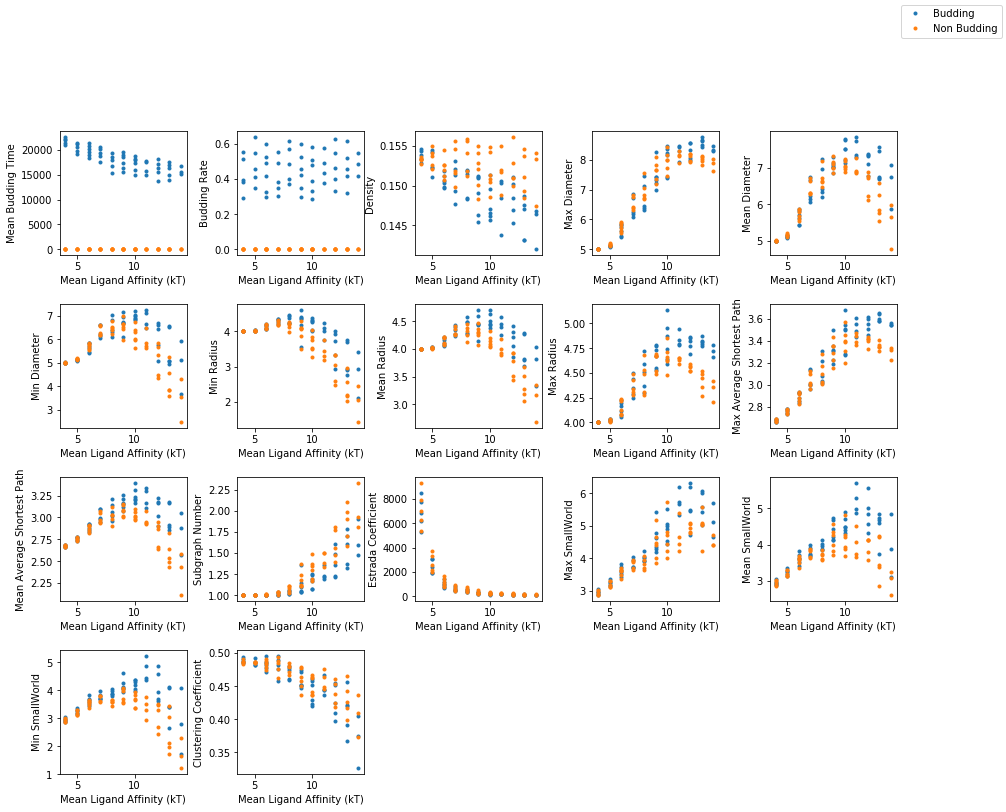

In [46]:
i = 1


fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in budNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(5, 5, i)
    ax.plot(budNets['Mean Affinity'],budNets[c],'.',label="Budding")
    ax.plot(nonbudNets['Mean Affinity'],nonbudNets[c],'.',label="Non Budding")
    plt.ylabel(c)
    plt.xlabel("Mean Ligand Affinity (kT)")
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

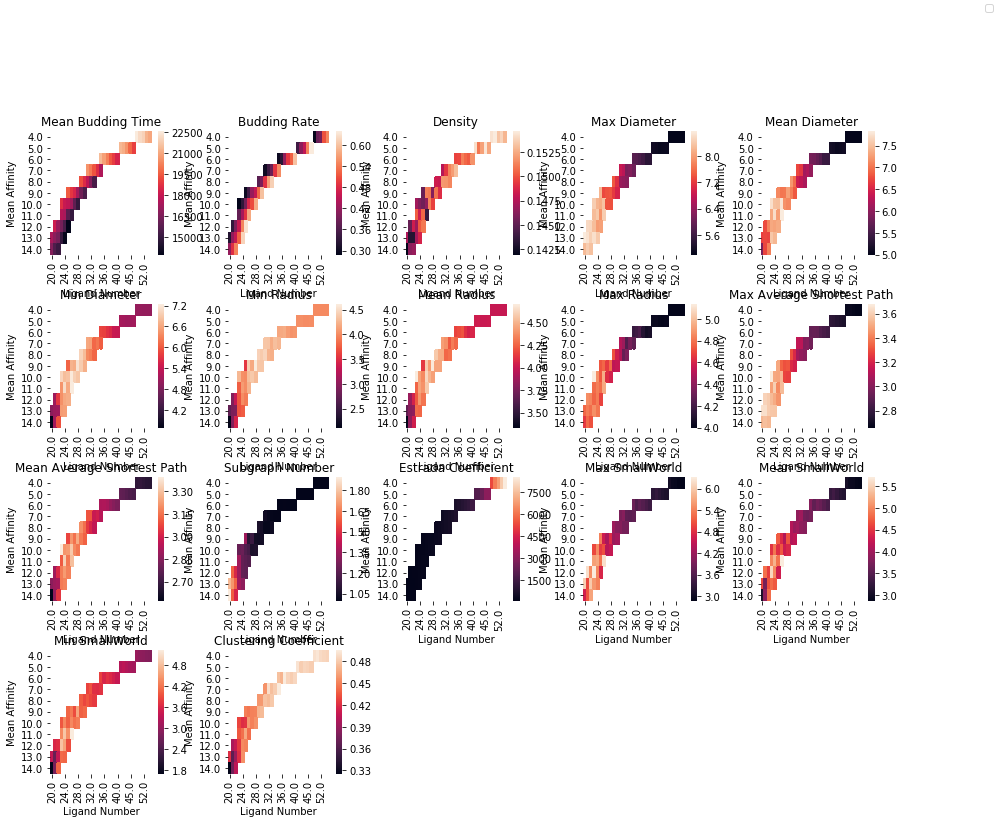

In [47]:
i = 1
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in budNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(5, 5, i)
    budNetsT = budNets.pivot("Mean Affinity", "Ligand Number", c)
    ax = sns.heatmap(budNetsT)
    ax.set_title(c)
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

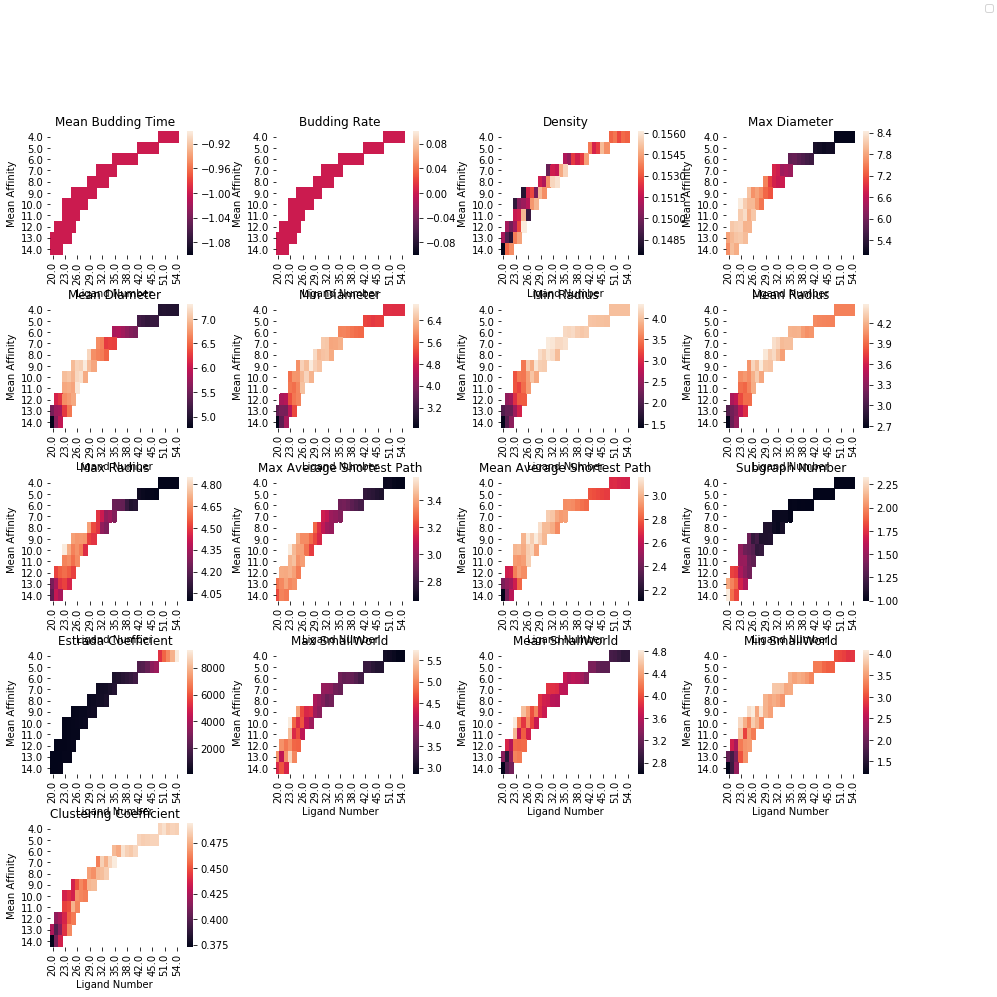

In [56]:
i = 1
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in budNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(5, 4, i)
    nonbudNetsT = nonbudNets.pivot("Mean Affinity", "Ligand Number", c)
    ax.set_title(c)
    ax = sns.heatmap(nonbudNetsT)
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

In [49]:
bins = np.linspace(0, 100, 26)
print bins

digitisedLigandNum = np.digitize(meanBudNets["Ligand Number"], bins)
binnedLigandNum = [meanBudNets["Ligand Number"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]
binnedNonBudLigandNum = [meanNonbudNets["Ligand Number"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]
binnedBuddingRate = [meanBudNets["Budding Rate"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]

binnedLigandNum = [b for b in binnedLigandNum if not np.isnan(b)]
binnedNonBudLigandNum = [b for b in binnedNonBudLigandNum if not np.isnan(b)]
binnedBuddingRate = [b for b in binnedBuddingRate if not np.isnan(b)]


[  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.
  56.  60.  64.  68.  72.  76.  80.  84.  88.  92.  96. 100.]


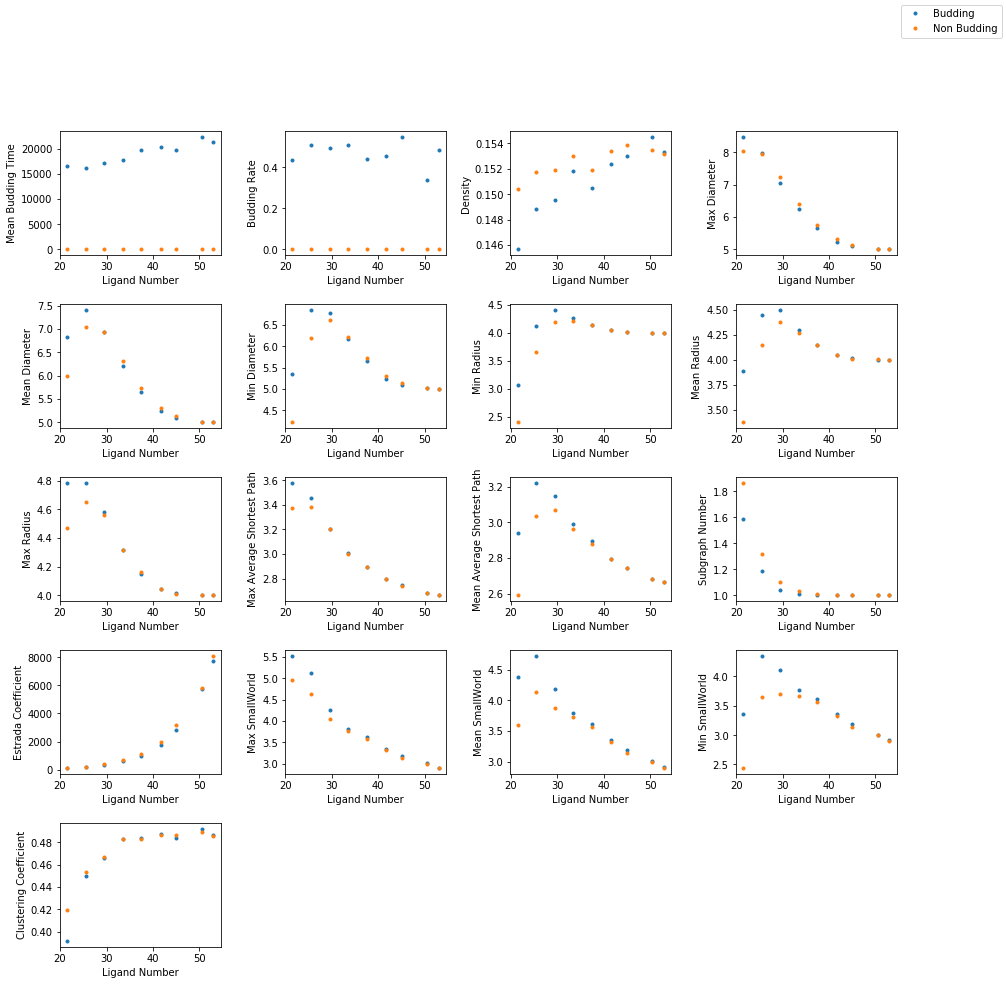

In [57]:
i = 1
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in meanBudNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(5, 4, i)
    binnedBudC = [meanBudNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
    binnedBudC = [b for b in binnedBudC if not np.isnan(b)]
    binnedNoBudC = [meanNonbudNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
    binnedNoBudC = [b for b in binnedNoBudC if not np.isnan(b)]
    ax.plot(binnedLigandNum,binnedBudC,'.',label="Budding")
    ax.plot(binnedNonBudLigandNum,binnedNoBudC,'.',label="Non Budding")
    plt.ylabel(c)
    plt.xlabel("Ligand Number")
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

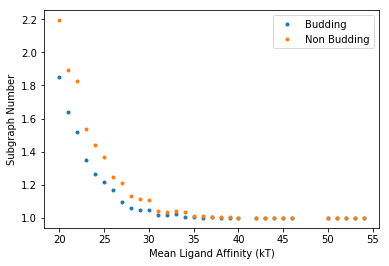

In [58]:
c = 'Subgraph Number'
plt.plot(meanBudNets['Ligand Number'],meanBudNets[c],'.',label="Budding")
plt.plot(meanNonbudNets['Ligand Number'],meanNonbudNets[c],'.',label="Non Budding")
plt.ylabel(c)
plt.xlabel("Mean Ligand Affinity (kT)")
plt.legend()
plt.show()

In [59]:
budNets = criticalNets[criticalNets['Mean Budding Time'] > 0.0].groupby(['Mean Affinity']).mean().reset_index()
nonbudNets = criticalNets[criticalNets['Mean Budding Time'] < 0.0].groupby(['Mean Affinity']).mean().reset_index()

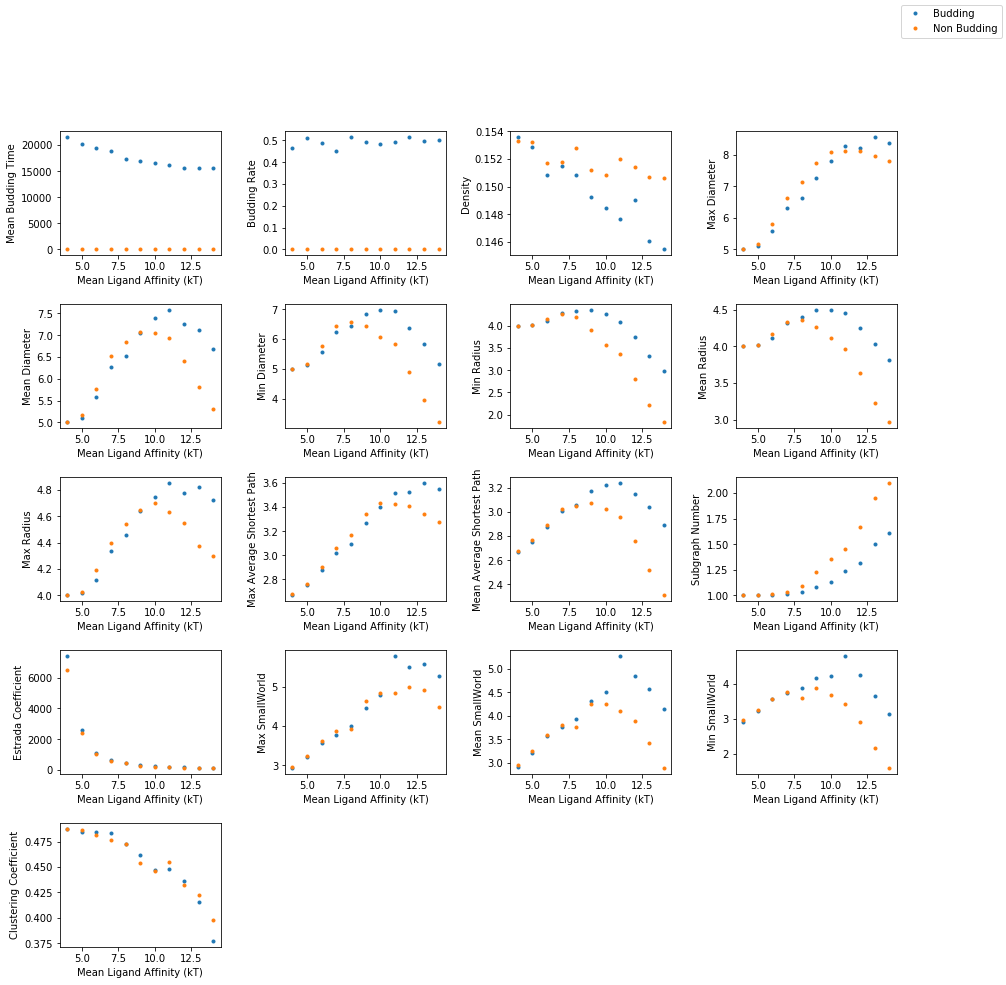

In [61]:
i = 1


fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in budNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(5, 4, i)
    ax.plot(budNets['Mean Affinity'],budNets[c],'.',label="Budding")
    ax.plot(nonbudNets['Mean Affinity'],nonbudNets[c],'.',label="Non Budding")
    plt.ylabel(c)
    plt.xlabel("Mean Ligand Affinity (kT)")
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

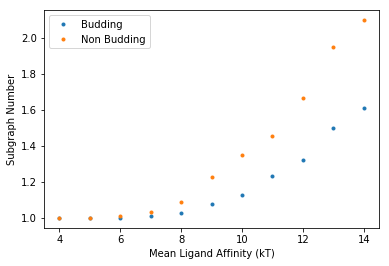

In [62]:
c = 'Subgraph Number'
plt.plot(budNets['Mean Affinity'],budNets[c],'.',label="Budding")
plt.plot(nonbudNets['Mean Affinity'],nonbudNets[c],'.',label="Non Budding")
plt.ylabel(c)
plt.xlabel("Mean Ligand Affinity (kT)")
plt.legend()
plt.show()

In [63]:
zoo_df = pd.read_csv('/Users/joel/Projects/golden/zoo.csv',names=['name','n','e','fitness','bud_rate','budtime'])

IOError: [Errno 2] File /Users/joel/Projects/golden/zoo.csv does not exist: '/Users/joel/Projects/golden/zoo.csv'

NameError: name 'zoo_df' is not defined

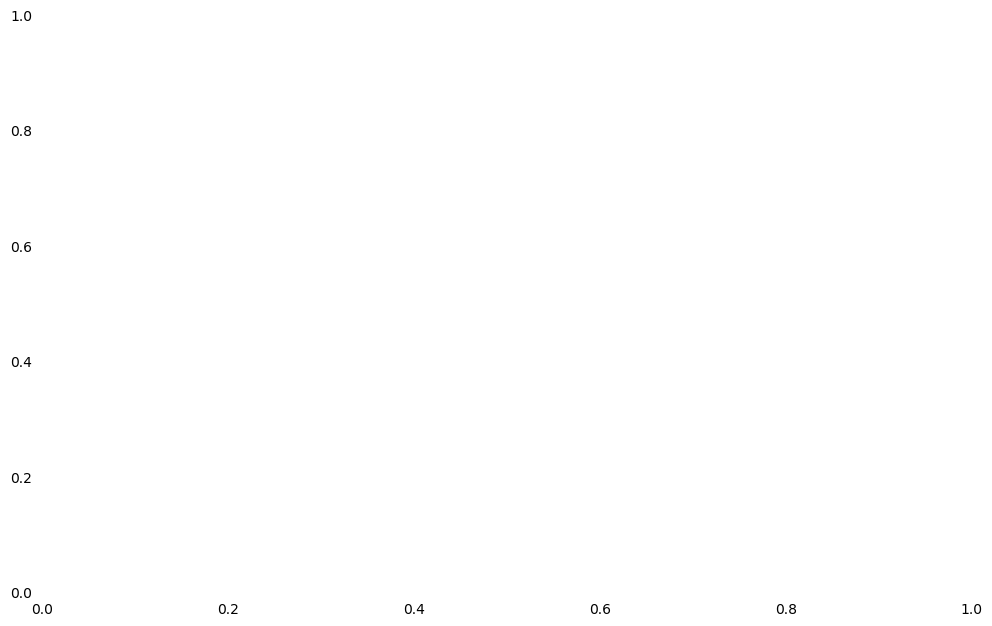

In [66]:
import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')
plt.figure(figsize=(12,7.5))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                    labelbottom="on", left="off", right="off", labelleft="on") 
plt.plot(zoo_df[zoo_df['budtime']>0]['n'],zoo_df[zoo_df['budtime']>0]['budtime'],'o',label="Evenly Covered")
plt.plot(budNets[budNets['Mean Budding Time']>0]['Ligand Number'],budNets[budNets['Mean Budding Time']>0]['Mean Budding Time'],'o',label="Evolved")
plt.ylabel('Budding Time',fontsize=16)
plt.xlabel("Ligand Number",fontsize=16)
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
                # specify integer or one of preset strings, e.g.
                #tick.label.set_fontsize('x-small') 
plt.ylim(0,25000)
plt.legend(fontsize=16)
plt.show()

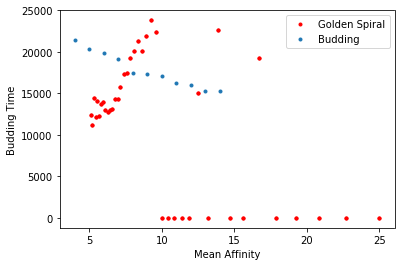

In [26]:
plt.plot(zoo_df['e'],zoo_df['budtime'],'.',label="Golden Spiral",color="red")
plt.plot(budNets['Mean Affinity'],budNets['Mean Budding Time'],'.',label="Budding")
plt.ylabel('Budding Time')
plt.xlabel("Mean Affinity")
plt.legend()
plt.show()

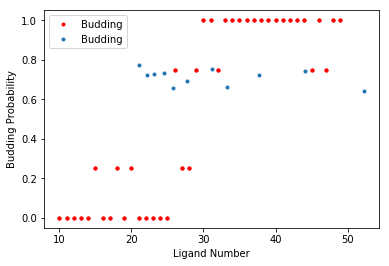

In [27]:
plt.plot(zoo_df['n'],zoo_df['bud_rate'],'.',label="Budding",color="red")
plt.plot(budNets['Ligand Number'],budNets['Budding Rate'],'.',label="Budding")
plt.ylabel('Budding Probability')
plt.xlabel("Ligand Number")
plt.legend()
plt.show()

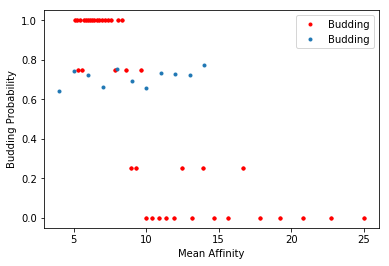

In [28]:
plt.plot(zoo_df['e'],zoo_df['bud_rate'],'.',label="Budding",color="red")
plt.plot(budNets['Mean Affinity'],budNets['Budding Rate'],'.',label="Budding")
plt.ylabel('Budding Probability')
plt.xlabel("Mean Affinity")
plt.legend()
plt.show()

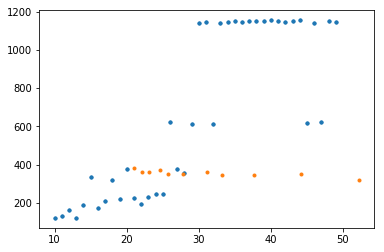

In [29]:
plt.plot(zoo_df['n'],zoo_df['fitness'],'.',label="Budding")
plt.plot(budNets['Ligand Number'],budNets['Fitness'],'.',label="Budding")

In [70]:
# net_df[(net_df['Ligand Number']==23) & (net_df['Mean Affinity']==10)].sort_values("Subgraph Number")

In [71]:

net_df[(net_df['Fitness']==158.750000)&(net_df['Ligand Number']==23) & (net_df['Mean Affinity']==10) ].sort_values(["Subgraph Number","Density"])



,Ligand Number,Mean Affinity,Fitness,Mean Budding Time,Budding Rate,Density,Max Diameter,Mean Diameter,Min Diameter,Min Radius,...,Max Average Shortest Path,Mean Average Shortest Path,Min Average Shortest Path,Subgraph Number,Estrada Coefficient,Pruning,Max SmallWorld,Mean SmallWorld,Min SmallWorld,Clustering Coefficient
2109,23,10.0,158.75,-1.0,0.0,0.162055,4,3.0,2,1,...,1.933333,1.57963,1.333333,3,218.644226,0.3,3.432343,1.97378,1.118906,0.566253


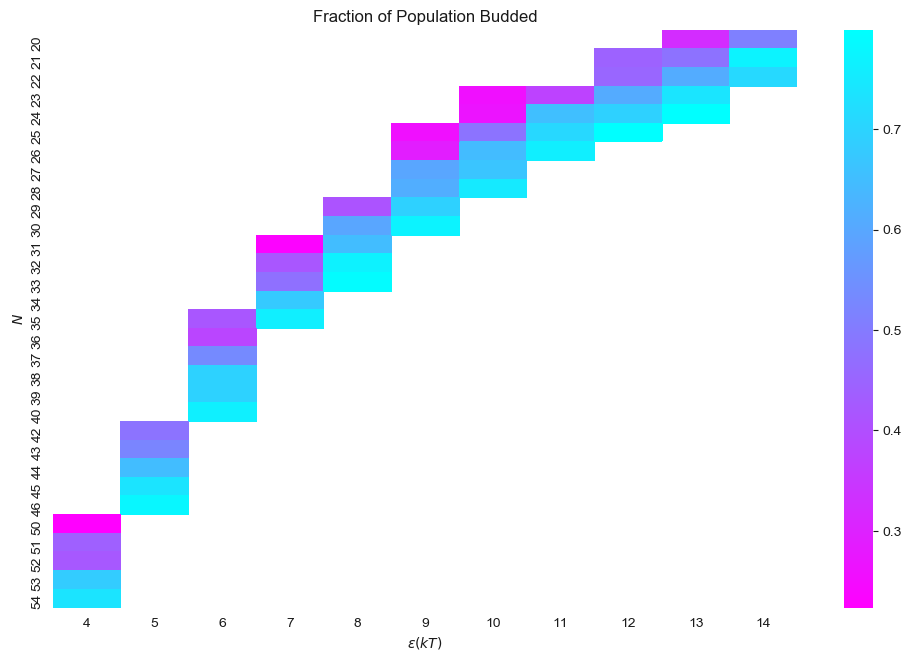

In [73]:
plt.figure(figsize=(12,7.5))
result = bud_df.pivot(index='e', columns='n', values='bud_percentage')
sns.heatmap(result,cmap='cool_r')
plt.title('Fraction of Population Budded')
plt.xlabel("$\epsilon (kT)$")
plt.ylabel("$N$")
sns.set(font_scale=2.1)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                    labelbottom="on", left="off", right="off", labelleft="on") 
    
plt.show()

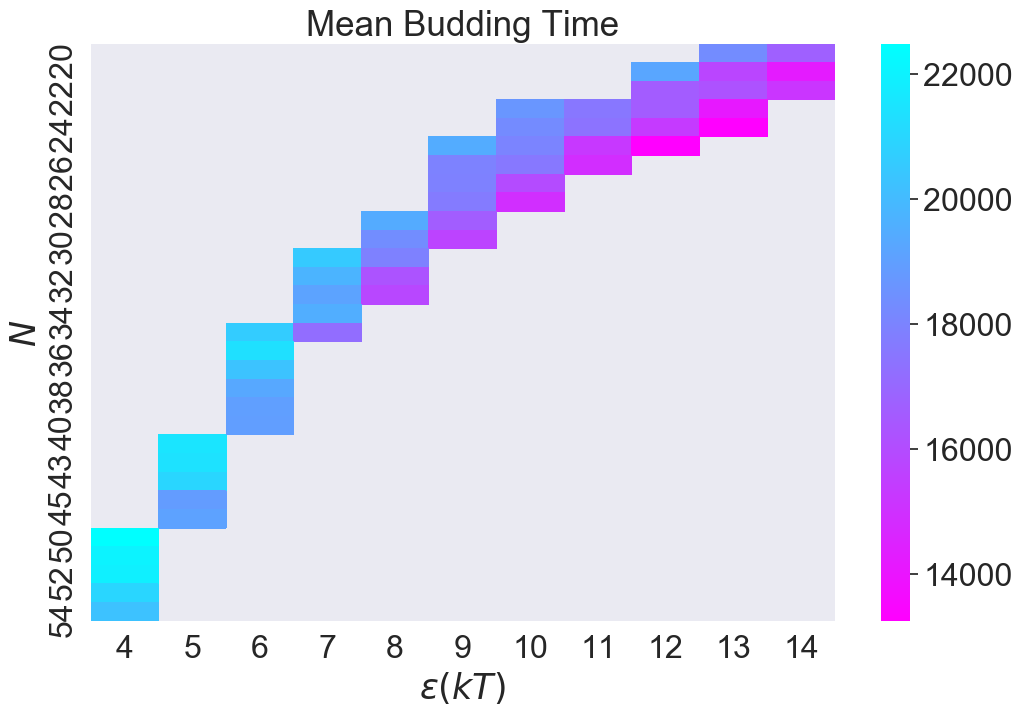

In [74]:
plt.figure(figsize=(12,7.5))
result = bud_df[bud_df['mean_budtime']>0].pivot(index='e', columns='n', values='mean_budtime')
sns.heatmap(result,cmap='cool_r')
plt.title('Mean Budding Time')
plt.xlabel("$\epsilon (kT)$")
plt.ylabel("$N$")
sns.set(font_scale=2.1)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                    labelbottom="on", left="off", right="off", labelleft="on") 
    
plt.show()

In [76]:
spec_df = pd.read_csv('/Users/joelforster/Projects/optihedron/opti-spectrum.csv')

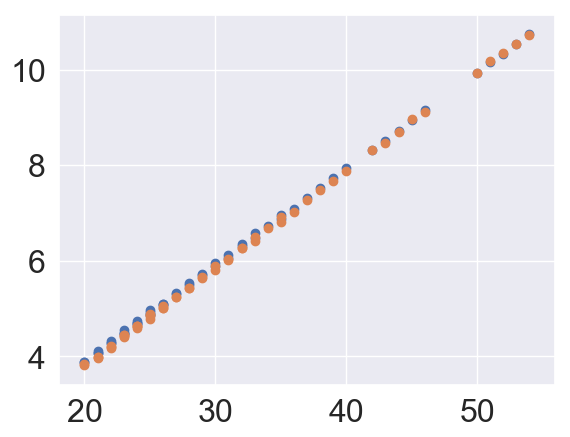

In [78]:
cR = [[20, 13], [20, 14], [21, 12], [21, 13], [21, 14], [22, 12], [22, 13], [22, 14], [23, 10], [23, 11], [23, 12], [23, 13], [24, 10], [24, 11], [24, 12], [24, 13], [25, 9], [25, 10], [25, 11], [25, 12], [26, 9], [26, 10], [26, 11], [27, 9], [27, 10], [28, 9], [28, 10], [29, 8], [29, 9], [30, 8], [30, 9], [31, 7], [31, 8], [32, 7], [32, 8], [33, 7], [33, 8], [34, 7], [35, 6], [35, 7], [36, 6], [37, 6], [38, 6], [39, 6], [40, 6], [42, 5], [43, 5], [44, 5], [45, 5], [46, 5], [50, 4], [51, 4], [52, 4], [53, 4], [54, 4]]
bRadMean = []
nRadMean = []
specAvgs = {}
for c in cR:
    s = spec_df[(spec_df['e']==float(c[-1])) & (spec_df['n']==float(c[0]))]
    bspec = []
    nspec = []
    brad = []
    nrad = []
    for spec in s[s['budtime']>-1]['spectrum'].values.tolist():
        speclist = [float(eig) for eig in spec[1:len(spec)-1].split(',')]
        bspec.append(speclist)
        brad.append(max(speclist))
    for spec in s[s['budtime']<0]['spectrum'].values.tolist():
        speclist = [float(eig) for eig in spec[1:len(spec)-1].split(',')]
        nspec.append(speclist)
        nrad.append(max(speclist))
    if not c[0] in specAvgs:
        specAvgs[c[0]]={}
    specAvgs[c[0]][c[-1]] = {}
    specAvgs[c[0]][c[-1]]['b'] = np.mean(bspec, axis=0, dtype=None, out=None, keepdims=False)
    specAvgs[c[0]][c[-1]]['n'] = np.mean(nspec, axis=0, dtype=None, out=None, keepdims=False)
#     sns.distplot(nrad,bins=np.linspace(min(nrad),max(nrad),40),kde=False,norm_hist=True)
#     sns.distplot(brad,bins=np.linspace(min(brad),max(brad),40),kde=False,norm_hist=True)
    bRadMean.append([c[0],c[1],np.mean(brad)])
    nRadMean.append([c[0],c[1],np.mean(nrad)])
plt.scatter([i[0] for i in nRadMean],[i[2] for i in nRadMean])
plt.scatter([i[0] for i in bRadMean],[i[2] for i in bRadMean])

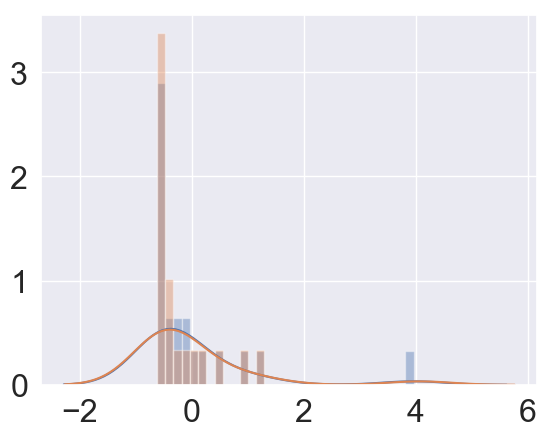

In [79]:
se = 12
sn = 21

sns.distplot(specAvgs[sn][se]['b'],bins=np.linspace(np.min(specAvgs[sn][se]['b']),np.max(specAvgs[sn][se]['b']),32),norm_hist=True)
sns.distplot(specAvgs[sn][se]['n'],bins=np.linspace(np.min(specAvgs[sn][se]['b']),np.max(specAvgs[sn][se]['b']),32),norm_hist=True)

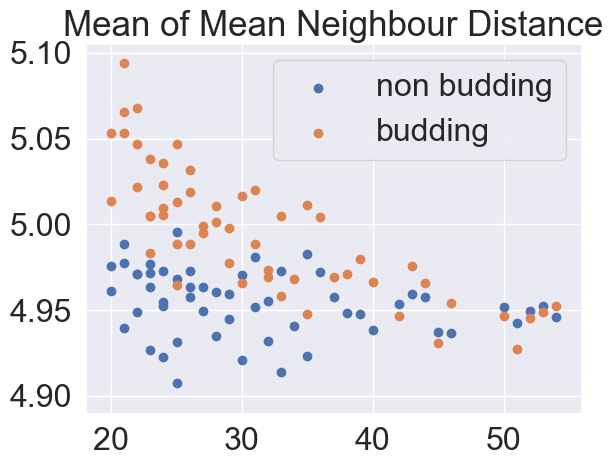

In [80]:
nDistMean = []
bDistMean = []
nDistMin = []
bDistMin = []
nDistMax = []
bDistMax = []
for c in cR:
    s = spec_df[(spec_df['e']==float(c[-1])) & (spec_df['n']==float(c[0]))]
    bdist = []
    ndist = []
    for dist in s[s['budtime']>-1]['mean_dist'].values.tolist():
        fdist = float(dist)
        bdist.append(fdist)
    for dist in s[s['budtime']<0]['mean_dist'].values.tolist():
        fdist = float(dist)
        ndist.append(fdist)
    nDistMean.append([c[0],c[1],1.0/np.mean(ndist)])
    bDistMean.append([c[0],c[1],1.0/np.mean(bdist)])
    nDistMin.append([c[0],c[1],1.0/np.min(ndist)])
    bDistMin.append([c[0],c[1],1.0/np.min(bdist)])
    nDistMax.append([c[0],c[1],1.0/np.max(ndist)])
    bDistMax.append([c[0],c[1],1.0/np.max(bdist)])

# sns.distplot(ndist,bins=np.linspace(min(ndist),max(ndist),40),kde=False,norm_hist=True)
# sns.distplot(bdist,bins=np.linspace(min(bdist),max(bdist),40),kde=False,norm_hist=True)

plt.scatter([i[0] for i in nDistMean],[i[2] for i in nDistMean],label='non budding')
plt.scatter([i[0] for i in bDistMean],[i[2] for i in bDistMean],label='budding')
plt.title('Mean of Mean Neighbour Distance')
plt.legend()
plt.show()

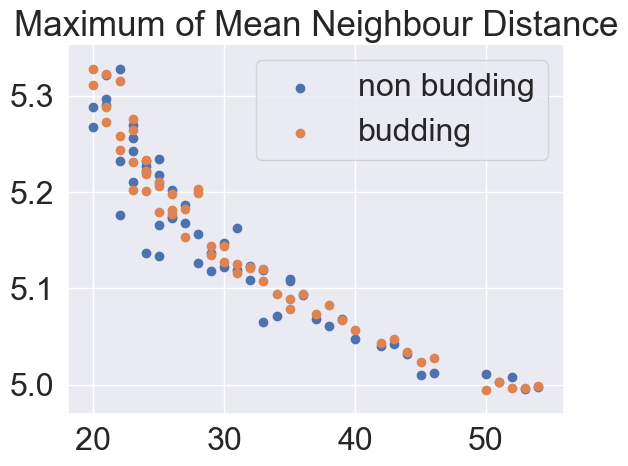

In [81]:
plt.scatter([i[0] for i in nDistMin],[i[2] for i in nDistMin],label='non budding')
plt.scatter([i[0] for i in bDistMin],[i[2] for i in bDistMin],label='budding')
plt.title('Maximum of Mean Neighbour Distance')
plt.legend()
plt.show()

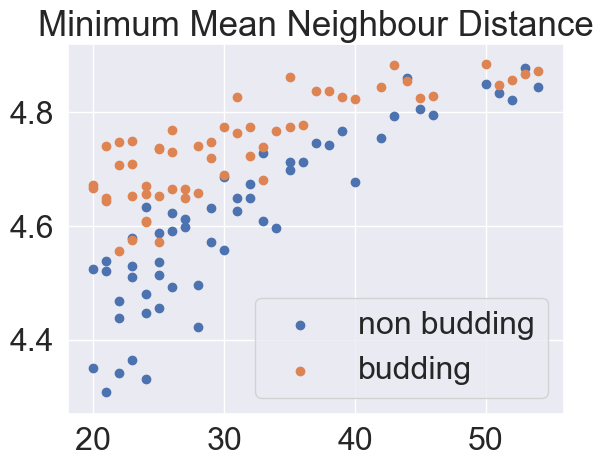

In [82]:
plt.scatter([i[0] for i in nDistMax],[i[2] for i in nDistMax],label='non budding')
plt.scatter([i[0] for i in bDistMax],[i[2] for i in bDistMax],label='budding')
plt.title('Minimum Mean Neighbour Distance')
plt.legend()
plt.show()

In [66]:
min(net_df['Estrada Coefficient'])

48.197985417299996

,Ligand Number,Mean Affinity,Fitness,Mean Budding Time,Budding Rate,Density,Max Diameter,Mean Diameter,Min Diameter,Min Radius,...,Max Average Shortest Path,Mean Average Shortest Path,Min Average Shortest Path,Subgraph Number,Estrada Coefficient,Pruning,Max SmallWorld,Mean SmallWorld,Min SmallWorld,Clustering Coefficient
9,23.0,10.0,246.376050,23800.000000,0.25,0.146245,9.0,9.0,9.0,5.0,...,4.079051,4.079051,4.079051,1.0,120.534423,0.3,7.234245,7.234245,7.234245,0.550725
11,23.0,10.0,268.630184,21700.000000,0.25,0.158103,8.0,8.0,8.0,4.0,...,3.573123,3.573123,3.573123,1.0,141.232087,0.3,0.000000,0.000000,0.000000,0.513043
17,23.0,10.0,272.843361,24100.000000,0.25,0.134387,10.0,10.0,10.0,5.0,...,3.865613,3.865613,3.865613,1.0,97.440997,0.3,6.434367,6.434367,6.434367,0.362319
39,23.0,10.0,342.599887,18600.000000,0.50,0.150198,8.0,8.0,8.0,6.0,...,3.774704,3.774704,3.774704,1.0,131.029158,0.3,3.888594,3.888594,3.888594,0.463768
41,23.0,10.0,261.282258,15500.000000,0.25,0.142292,10.0,10.0,10.0,5.0,...,4.114625,4.114625,4.114625,1.0,121.786582,0.3,5.105160,5.105160,5.105160,0.466667
42,23.0,10.0,288.471649,19400.000000,0.25,0.126482,7.0,4.0,1.0,1.0,...,3.290476,2.145238,1.000000,2.0,87.578756,0.3,2.392919,1.196459,0.000000,0.239130
52,23.0,10.0,251.815315,22200.000000,0.25,0.146245,12.0,12.0,12.0,6.0,...,4.664032,4.664032,4.664032,1.0,146.411063,0.3,3.285510,3.285510,3.285510,0.436232
55,23.0,10.0,247.432403,23300.000000,0.25,0.146245,9.0,9.0,9.0,5.0,...,3.549407,3.549407,3.549407,1.0,116.768040,0.3,0.000000,0.000000,0.000000,0.371014
57,23.0,10.0,214.860215,18600.000000,0.25,0.130435,7.0,5.0,3.0,2.0,...,3.161905,2.402381,1.642857,2.0,112.932295,0.3,2.375678,2.274975,2.174273,0.420290
65,23.0,10.0,260.665301,18300.000000,0.25,0.158103,6.0,6.0,6.0,5.0,...,3.086957,3.086957,3.086957,1.0,137.839657,0.3,10.984794,10.984794,10.984794,0.476812


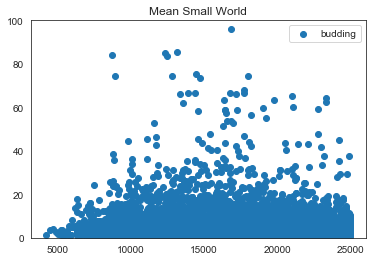

In [54]:
plt.scatter(net_df[net_df["Mean Budding Time"] > 0]['Mean Budding Time'].values,net_df[net_df["Mean Budding Time"] > 0]['Mean SmallWorld'].values,label='budding')
plt.title('Mean Small World')
plt.ylim(0,100)
plt.legend()
plt.show()

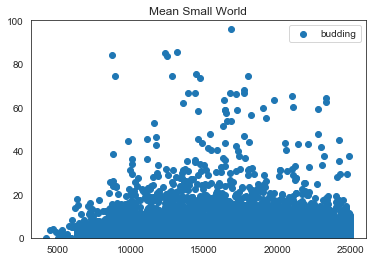

In [55]:
plt.scatter(net_df[net_df["Mean Budding Time"] > 0]['Mean Budding Time'].values,net_df[net_df["Mean Budding Time"] > 0]['Min SmallWorld'].values,label='budding')
plt.title('Mean Small World')
plt.ylim(0,100)
plt.legend()
plt.show()

/Users/joelforster/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


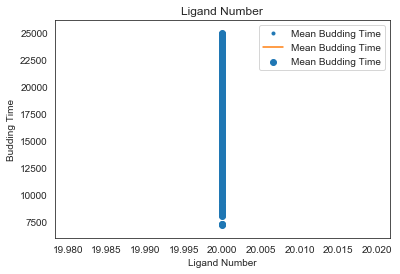

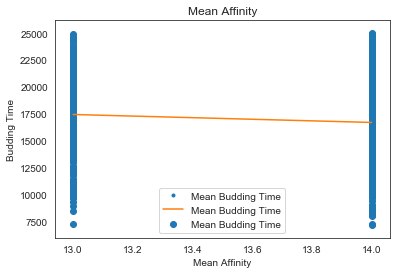

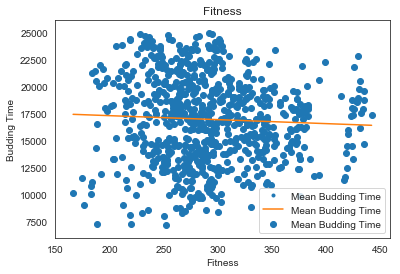

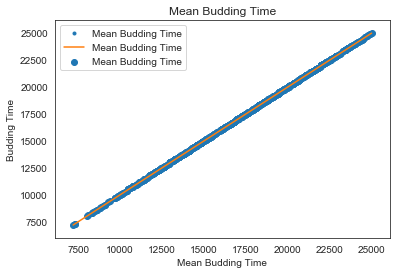

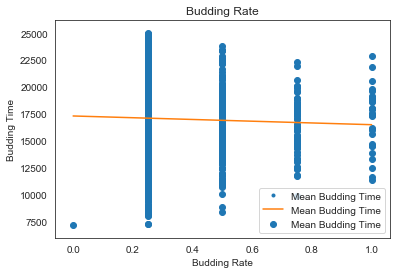

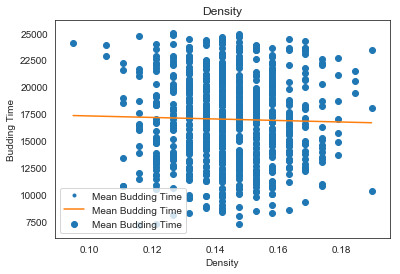

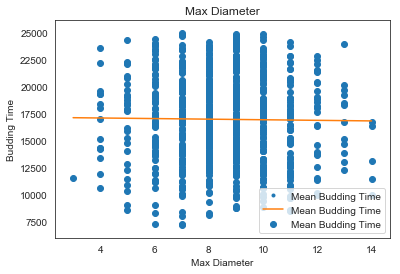

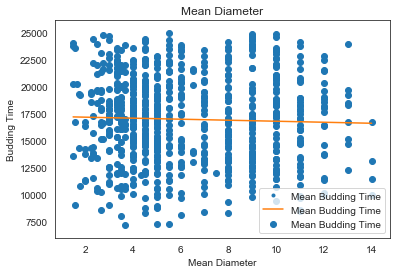

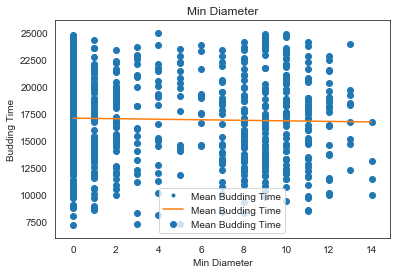

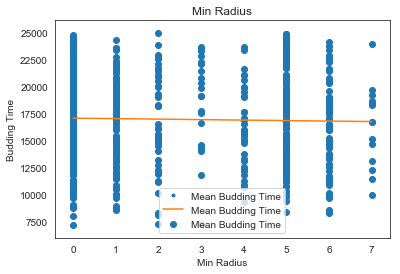

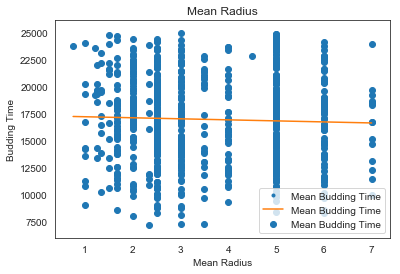

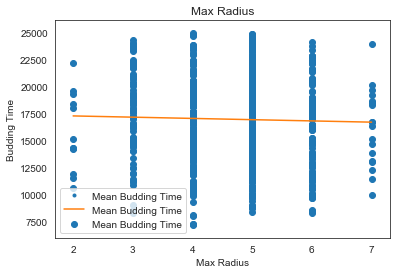

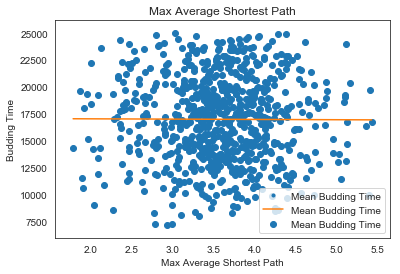

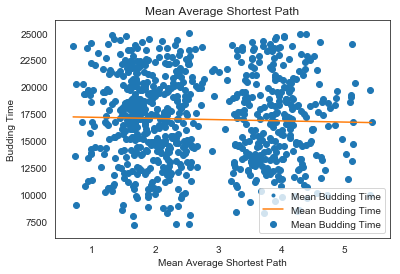

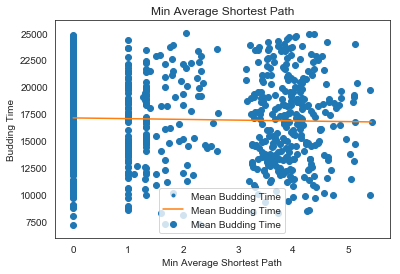

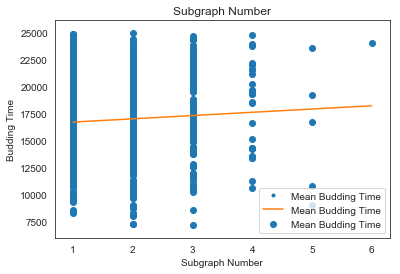

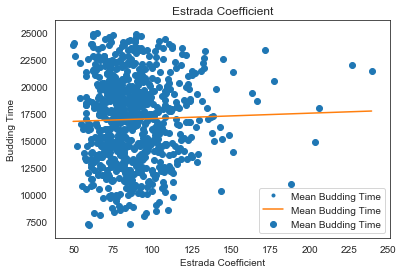

/Users/joelforster/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


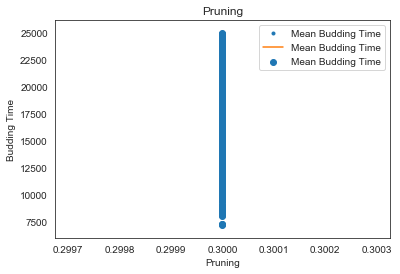

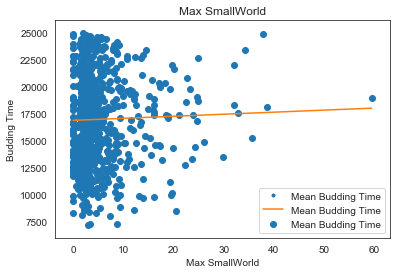

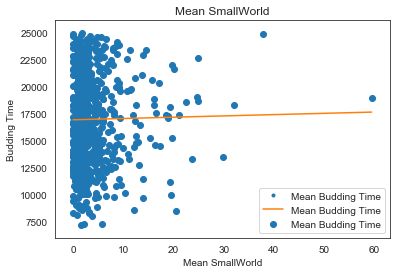

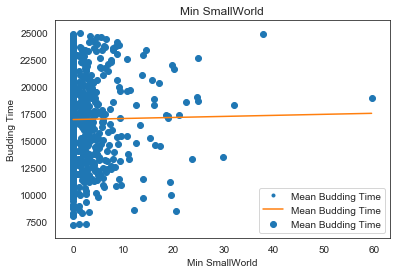

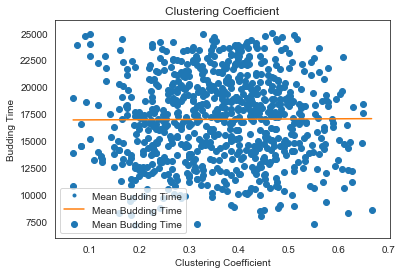

In [106]:
for c in criticalNets.columns:
    d = criticalNets[(criticalNets["Mean Budding Time"] > 0) & (criticalNets["Ligand Number"] == 20)].sort_values(by=[c])
    y = d['Mean Budding Time']
    x = d[c]
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    z = np.polyfit(x, y, 1)
    f = np.poly1d(z)
    plt.plot(x,y,'.', x, f(x))
    plt.scatter(x,y)
    plt.title(c)
    plt.xlabel(c)
    plt.ylabel("Budding Time")
    
    plt.legend()
    plt.show()

In [ ]:
import nanoparticle
from tools import analysistools as atools

In [144]:
def randomParticleNetwork(n,pruning=0.3):
    a=np.ones(72)
    a[n:72]=0
    np.random.shuffle(a)
    phenome=nanoparticle.CoveredNanoParticlePhenome(a,1,0,10,10)
    particle = phenome.particle
    net = atools.buildLigandNetwork(particle.ligands)
    pN = atools.pruneNetwork(net,pruning)
    return pN
    

In [167]:
def particleSummary(pN):
    density = nx.density(pN)
    avgC = nx.average_clustering(pN)
    graphs = list(nx.connected_component_subgraphs(pN))
    dS = []
    rS = []
    sPS = []
    SWs = []

    for g in graphs:
        d = nx.diameter(g)
        r = nx.radius(g)
        sp = nx.average_shortest_path_length(g)
        dS.append(d)
        rS.append(r)
        sPS.append(sp)
        SWs.append(atools.smallWorldNess(g))

    maxDiameter = np.max(dS)
    avgDiameter = np.mean(dS)
    minDiameter = np.min(dS)
    minRadius = np.min(rS)
    avgRadius = np.mean(rS)
    maxRadius = np.max(rS)
    maxASp = np.max(sPS)
    avgASp = np.mean(sPS)
    minASp = np.min(sPS)
    maxSW = np.max(SWs)
    avgSW = np.mean(SWs)
    minSW = np.min(SWs)
    subgraphs = len(graphs)
    estrada = nx.estrada_index(pN)
    l = [density,
        maxDiameter,
          avgDiameter,
          minDiameter,
          minRadius,
          avgRadius,
          maxRadius,
          maxASp,
          avgASp,
          minASp,
          subgraphs,
          estrada,
          maxSW,
          avgSW,
          minSW,
          avgC]
    return l

In [ ]:
nLigs = 52
nets=[]
for i in range(3000):
    nets.append(randomParticleNetwork(nLigs,pruning=0.3))
    

rnddata = []
for n in nets:
    rnddata.append(particleSummary(n))

rnd_df=pd.DataFrame(columns=[
            "Density",
            "Max Diameter",
            "Mean Diameter",
            "Min Diameter",
            "Min Radius",
            "Mean Radius",
            "Max Radius",
            "Max Average Shortest Path",
            "Mean Average Shortest Path",
            "Min Average Shortest Path",
            "Subgraph Number",
            "Estrada Coefficient",
            "Max SmallWorld",
            "Mean SmallWorld",
            "Min SmallWorld",
            "Clustering Coefficient"],data=rnddata)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
startI = 20
# for i in range(startI,startI+16):
#     ax = plt.subplot(4, 4, i-startI+1)
#     r = buildHistPlot(c,i)
#     ax = sns.distplot(r[0],label="Budding",bins=25,kde=False)
#     ax = sns.distplot(r[1],label="Non Budding",bins=25,kde=False)
#     ax.set_xlabel(c)
#     ax.set_ylabel("Population")
#     ax.set_title(i)

for i,c in enumerate(rnd_df.columns):
    ax = plt.subplot(4, 6, i+1)
    r = buildHistPlot(c,nLigs)
    ax = sns.distplot(rnd_df[c].values,label="Random",bins=12,kde=True)
    ax = sns.distplot(r[0],label="Budding",bins=12,kde=True)
#     ax = sns.distplot(r[1],label="Non Budding",bins=12,kde=False)
    ax.set_xlabel(c)
    ax.set_ylabel("Population")
    ax.set_title(i)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()